# Statistics on the output data. 

### Loading data from the sqlite database to the dataframes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random
from tabulate import tabulate

warnings.filterwarnings("ignore")
fig_dir = Path('figure').mkdir(parents=True, exist_ok=True)
fig_dir = Path('figure')
result_dir = Path('result').mkdir(parents=True, exist_ok=True)
result_dir = Path('result')

database = "/Users/guru/research/VulnMiner/data/VulnMinerV1.db"
conn= connect(database)
random.seed(0)

In [2]:
dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)
dfs.columns

Index(['file', 'line', 'column', 'defaultlevel', 'level', 'category', 'name',
       'msg', 'note', 'cwe', 'context', 'helpuri', 'severity', 'tool', 'type',
       'project'],
      dtype='object')

### Plotting subburset plot from the frequency of category, name and cwe types. 

In [3]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')

dfplt['category'] = dfplt.apply(lambda row: row['category'] 
if row['category']==row['name'] or row['name']=='-' 
else row['name'], axis=1)
dfplt = dfplt.drop(labels=['name'], axis=1)

fig = px.sunburst(dfplt, 
    path=['category', 'cwe'],
    values='count', 
    color_continuous_scale='Reds',
    color='count',
)

fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [84]:
# Create a treemap from the same data
fig = px.treemap(dfplt, 
    path=['category', 'cwe'],
    values='count',
    color='count',
    color_continuous_scale='Reds',
    title='Treemap'
)

# Update layout if necessary
fig.update_layout(
    autosize=True,
    width=800,
    height=800,
    font=dict( 
        size=16,
    )
)
# Show the treemap
fig.show()
fig.write_image(fig_dir / "vul-statistics.png", width=800, height=800)

In [5]:
dfplt.sort_values(by=['count'], ascending=False).head(10)

,category,cwe,count
84,memcpy,CWE-120,29198
67,char,CWE-119!/CWE-120,22051
95,strlen,CWE-126,8947
90,sprintf,CWE-120,6470
59,StrCat,CWE-120,4226
86,read,"CWE-120, CWE-20",3015
94,strcpy,CWE-120,2756
145,open,CWE-362,2072
44,syntaxError,CWE-unknown,1580
47,uninitvar,CWE-457,1554


# Top 10 vulnerabilities

In [6]:
df_top10 = dfplt.sort_values(by=['count'], ascending=False).head(10).reset_index(drop=True)
print(tabulate(df_top10, headers='keys', tablefmt='psql'))
df_top10.to_latex(result_dir / "top10.tex", index=False, caption="Top 10 CWEs in IoT code")

+----+-------------+------------------+---------+
|    | category    | cwe              |   count |
|----+-------------+------------------+---------|
|  0 | memcpy      | CWE-120          |   29198 |
|  1 | char        | CWE-119!/CWE-120 |   22051 |
|  2 | strlen      | CWE-126          |    8947 |
|  3 | sprintf     | CWE-120          |    6470 |
|  4 | StrCat      | CWE-120          |    4226 |
|  5 | read        | CWE-120, CWE-20  |    3015 |
|  6 | strcpy      | CWE-120          |    2756 |
|  7 | open        | CWE-362          |    2072 |
|  8 | syntaxError | CWE-unknown      |    1580 |
|  9 | uninitvar   | CWE-457          |    1554 |
+----+-------------+------------------+---------+


<AxesSubplot: >

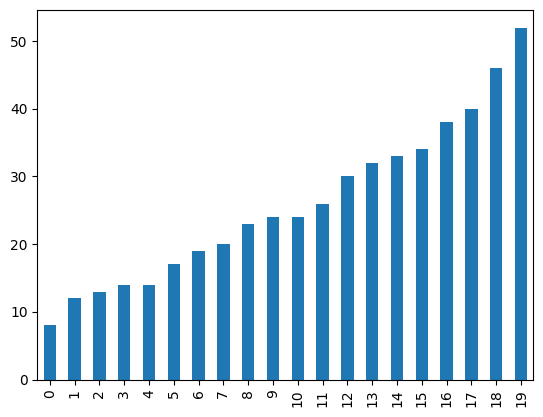

In [7]:
# dfs.context.head(200).str.len().plot(kind='bar')
pd.Series(sorted(list(dfs.context.head(20).str.len()))).plot(kind='bar')

In [8]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 

    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 151  #TODO: double check pep standards

# TODO: check min_len as well, otherwise the below code unnessesarily checks one extra condition 
# because there is no any statement/fun with len below that. 
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dff.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[51, 60, 1, 37, 68]

## Create a latex table from the statistics of projects

In [9]:
def save_latex(df, file):
    """
    save the dataframe as latex table
    """
    styler = df.style
    # styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
    styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
    res = styler.to_latex(convert_css=True, column_format='|l|l|r|')

    with open(file, 'w') as f:
        f.write(res)
    return res

# make class binary type benign/vulnerable
dfs_binary = dfs.copy()
dfs_binary.loc[dfs_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dfs_binary['project'] = dfs_binary.project.str.split('/').str[-1]

prj_stat = dfs_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_stat.groupby(['project', 'cwe']).sum()

res = tabulate(save_latex(prj_s, result_dir / 'project_stat.tex'))

In [10]:
dff_binary = dff.copy()
dff_binary.loc[dff_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dff_binary['project'] = dff_binary.project.str.split('/').str[-1]

prj_fun = dff_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_fun.groupby(['project', 'cwe']).sum()
prj_f = prj_f.reset_index()
prj_f

,project,cwe,count
0,ARMmbed,Benign,21378
1,ARMmbed,Vulnerable,4986
2,CycloneTCP,Benign,8760
3,CycloneTCP,Vulnerable,1837
4,FreeRTOS,Benign,16642
5,FreeRTOS,Vulnerable,3628
6,ImageMagick,Benign,2922
7,ImageMagick,Vulnerable,2109
8,OpenCV,Benign,2216
9,OpenCV,Vulnerable,84


In [80]:
prj_f = prj_f.rename(columns={'cwe':'cwef', 'count':'#function','project':'projectf'})
prj_stat = prj_stat.rename(columns={'count':'#statement'})

df_dist = pd.concat([prj_stat, prj_f], axis=1, join='inner')
df_dist = df_dist.sort_values(by=['#statement'], ascending=False)
df_dist = df_dist.drop(columns=['projectf', 'cwef'], axis=1)
df_dist = df_dist.set_index(['project', 'cwe'])
df_dist = df_dist.unstack()

# add total row
df_dist = pd.concat([df_dist, df_dist.sum().rename('TOTAL').to_frame().T], ignore_index=False)
df_dist.reset_index().to_latex('result/project-stat.tex', index=False)
print(f"Total #statements: {df_dist[-1:][0:2].T[0:2].sum().values[0]}")
print(f"Total #functions: {df_dist[-1:][0:2].T[2:4].sum().values[0]}")
df_dist

Total #statements: 2263907
Total #functions: 1026111


#statement            #function           
cwe                Benign Vulnerable    Benign Vulnerable
ARMmbed             62692       6091     21378       4986
CycloneTCP          17509       1129      8760       1837
FreeRTOS            67732       4112     16642       3628
ImageMagick         23477        442      2922       2109
OpenCV                467        107      2216         84
OpenSSL             32359       2379     10837       2318
RIOT                20759       2326      7550       2223
chromium           205146      11578    247596      10321
contiki              2775        274      1074        400
contiki-master      11864       1732      4379       1147
ffmpeg              74204       3309     13753       2984
gnucobol            17075       1342      1934        905
httpd               23540       1423      4494       1277
linux             1149066      44315    402864      48157
linux-rpi           63438        846     24290       4357
mbed-os               333         18       216         22
micropython         51310       3614     18855       4082
mosquitto            4088        490       820        558
openwrt              9436        855      3094        676
systemd             47900       2311     13337       2690
tcpdump              4573        201       528        191
tensorflow          81243       3804     35732       3903
tinyos               3420        439      1017        377
vlc                 40354       2446     10764       2051
wireshark          151090       2474     67421       2355
TOTAL             2165850      98057    922473     103638

In [87]:
print(f'Linux statements: {1149066+44315}')	
print(f'Linux functions: {402864+48157}')	

print(f'Chromium statements: {205146+11578}')
print(f'Chromium statements: {247596+10321}')

Linux statements: 1193381
Linux functions: 451021
Chromium statements: 216724
Chromium statements: 257917


In [12]:
dff['cwe'] = dff.cwe.str.replace(r"\['|']", "",regex=True)
dfs_cwe = dfs.cwe.value_counts().reset_index(name='#statements')
dff_cwe = dff.cwe.value_counts().reset_index(name='#functions')

dfs_cwe = dfs_cwe.rename(columns={'index':'cwe'})
dff_cwe = dff_cwe.rename(columns={'index':'cwe'})
df_cwe_count = pd.concat([dfs_cwe, dff_cwe], axis=1).head(10)
df_cwe_count = df_cwe_count.astype({"#functions": int})
df_cwe_count.to_latex('result/cwe-top-10.tex', index=False)
df_cwe_count

,cwe,#statements,cwe,#functions
0,Benign,2165850.0,Benign,922473
1,CWE-120,44737.0,CWE-120,42354
2,CWE-119!/CWE-120,22403.0,CWE-119!/CWE-120,19469
3,CWE-126,9371.0,CWE-126,10373
4,"CWE-120, CWE-20",3266.0,CWE-unknown,7049
5,CWE-190,3127.0,CWE-457,5662
6,CWE-362,2950.0,"CWE-120, CWE-20",3623
7,CWE-unknown,2394.0,CWE-362,3447
8,CWE-134,2293.0,CWE-190,3294
9,CWE-457,1668.0,CWE-134,1720


# Show the description of the function-level data

In [13]:
df_describe = dff_binary.drop(
    labels=['top_nesting_level', 'fan_in', 'fan_out', 'general_fan_out', 'content', 'long_name', 'fun_name', 'full_parameters', 'code'],
    axis=1, 
    errors='ignore').describe().T

df_freq = df_describe.reset_index().rename(columns={'index': 'features'})
df_freq = df_freq.drop(labels=['count'], axis=1)

# shortening the project URL to project name only 
df_freq['top'] = df_freq.apply(lambda row:row['top'].split('/')[-1] if '/' in row['top'] else row['top'], axis=1)

# The freq is the most common value’s frequency. The top is the most common value.
print(df_freq[~df_freq.features.isin(['file'])].to_latex(
    index=False,
    column_format='rrrrr', 
    label='Function Statistics', 
    caption='Function Statistics')
    )

\begin{table}
\caption{Function Statistics}
\label{Function Statistics}
\begin{tabular}{rrrrr}
\toprule
features & unique & top & freq \\
\midrule
context & 69182 &  & 922473 \\
cwe & 2 & Benign & 922473 \\
project & 25 & linux & 451021 \\
\bottomrule
\end{tabular}
\end{table}



In [14]:
print(f'Size of statements: {len(dfs.context)}')
print(f'Size of unique statements: {dfs.context.nunique()}')

print(f'\nSize of functions: {len(dff.code)}')
print(f'Size of unique functions: {dff.code.nunique()}')

Size of statements: 2263907
Size of unique statements: 2263431

Size of functions: 1026111
Size of unique functions: 1012833


# Token count of function-level data

In [15]:
from gensim.utils import simple_preprocess

fun_token_count = [len(simple_preprocess(x)) for x in dff.code]
stat_token_count = [len(simple_preprocess(x)) for x in dfs.context]

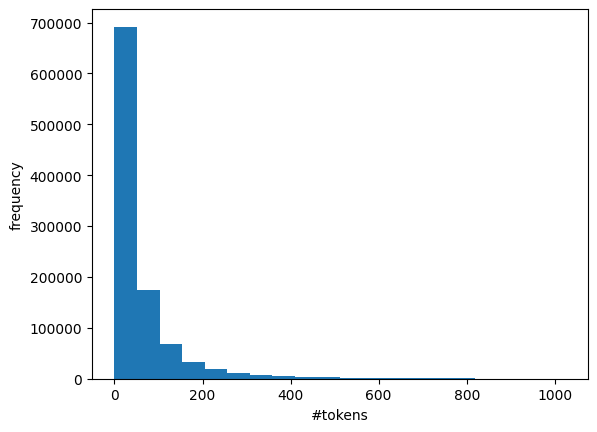

In [16]:
fun_token_count_short = [x for x in fun_token_count if x<=1024]
pd.Series(fun_token_count_short).plot.hist(bins=20)
plt.xlabel('#tokens')
plt.ylabel('frequency')
# plt.title('Function Token Count Distribution')
plt.savefig(fig_dir / 'fun_token_count.pdf')

In [17]:
# Combine descriptions into a DataFrame
combined_df = pd.DataFrame({
    'fun_token_count': pd.Series(stat_token_count).describe(),
    'stat_token_count': pd.Series(fun_token_count).describe()
})

print(combined_df)

       fun_token_count  stat_token_count
count     2.263907e+06      1.026111e+06
mean      3.766665e+00      6.515471e+01
std       2.568985e+00      2.326848e+02
min       0.000000e+00      0.000000e+00
25%       2.000000e+00      1.400000e+01
50%       3.000000e+00      3.000000e+01
75%       5.000000e+00      6.800000e+01
max       9.300000e+01      8.333000e+04


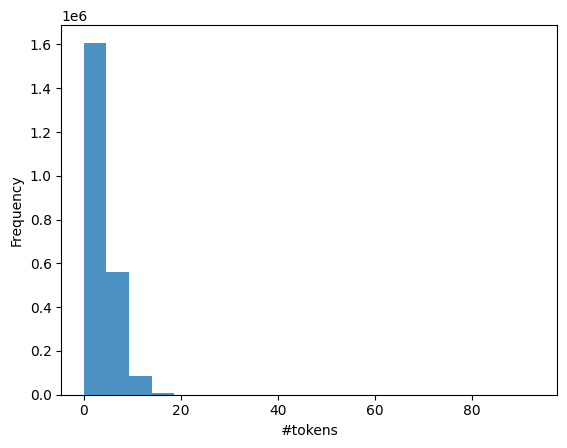

In [18]:
pd.Series(stat_token_count).plot.hist(bins=20, alpha=0.8)
plt.xlabel('#tokens')
plt.ylabel('Frequency')
plt.savefig(fig_dir / 'stat_token_count.pdf')

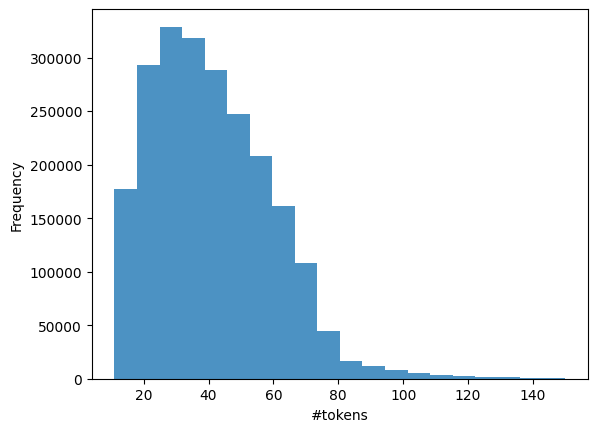

In [19]:
dfs1 = dfs[dfs.context.str.len()<151]
stat_char_len = [len(x) for x in dfs1.context if len(x)>10]
ax = pd.Series(stat_char_len).plot.hist(bins=20, xlabel='#chars', ylabel='#statements',alpha=0.8)
plt.xlabel('#tokens')
plt.ylabel('Frequency')
fighist = ax.get_figure()
fighist.savefig(fig_dir / 'statement-charlen.pdf')

In [20]:
dfs[dfs.file.str.len()<5].reset_index(drop=True)

,file,line,column,defaultlevel,level,category,name,msg,note,cwe,context,helpuri,severity,tool,type,project


In [21]:
dfs[dfs.file.str.len()<5].reset_index(drop=True)

,file,line,column,defaultlevel,level,category,name,msg,note,cwe,context,helpuri,severity,tool,type,project
